In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

/Users/haruka/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load data

In [2]:
def load_data(image_dir, labels_file):
    labels_df = pd.read_csv(labels_file)
    images = []
    labels = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    for index, row in labels_df.iterrows():
        # # if index % 10 == 0:
        #     print("Loading image", index)
            image_path = os.path.join(image_dir, str(index)+".jpg")
            if os.path.exists(image_path):
                image = cv2.imread(image_path)
                if image is None:
                    print("Error: Unable to read image at path:", image_path)
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                face = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(80, 80))
                if len(face) > 0:
                    (x, y, w, h) = face[0]  # first face detected
                    face_image = image[y:y+h, x:x+w]
                    face_image = cv2.resize(face_image, (100, 100))
                    images.append(face_image)
                    labels.append(row['Category'])
            else:
                print("Error: Image not found at path:", image_path)

    return np.array(images), np.array(labels)


In [ ]:
tr_img_path = "train"
tr_lb_path = "train.csv"
tr_img, tr_lb = load_data(tr_img_path, tr_lb_path)

(49464, 100, 100, 3) (49464,)
Adrianne Palicki


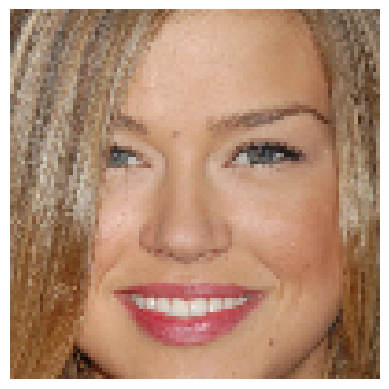

In [10]:
check_id = 1234
print(tr_img.shape, tr_lb.shape)

plt.imshow(tr_img[check_id])
plt.axis('off')
print(tr_lb[check_id])
plt.show()

## train CNN model

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn(out)
        out = self.conv2(out)
        out += identity
        out = self.relu(out)
        out = self.bn(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, padding=3)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(32)
        self.layer1 = self.make_layer(block, 32, num_blocks[0])
        self.layer2 = self.make_layer(block, 32, num_blocks[1])
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def make_layer(self, block, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        return out

# Define ResNet model
resnet = ResNet(ResNetBlock, num_blocks=[2, 2])  # Example: 2 blocks for each layer

# Modify the sequential model to use the ResNet
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=7),
    resnet,
    nn.Linear(32, 10)  # Adjust the output size according to your needs
)

# Print the model architecture
print(model)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (1): ResNet(
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): ResNetBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ResNetBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (layer2): Sequential(
      (0): ResNetBlock(
        (conv1): C

(39571, 100, 100, 3)
(9893, 100, 100, 3)
(39571,)
(9893,)
Epoch 1/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1489s 19s/step - accuracy: 0.0559 - loss: 50.5558 - val_accuracy: 0.1138 - val_loss: 4.0004
Epoch 2/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1389s 18s/step - accuracy: 0.2613 - loss: 3.3366 - val_accuracy: 0.4802 - val_loss: 2.5289
Epoch 3/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1391s 18s/step - accuracy: 0.6833 - loss: 1.5545 - val_accuracy: 0.5897 - val_loss: 2.0684
Epoch 4/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1485s 19s/step - accuracy: 0.8591 - loss: 0.7620 - val_accuracy: 0.6314 - val_loss: 1.9109
Epoch 5/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1451s 19s/step - accuracy: 0.9425 - loss: 0.3824 - val_accuracy: 0.6492 - val_loss: 1.8667
Epoch 6/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1541s 20s/step - accuracy: 0.9784 - loss: 0.1984 - val_accuracy: 0.6609 - val_loss: 1.8684
Epoch 7/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 1042s 13s/step - accuracy: 0.9898 - loss: 0.1194 - val_accuracy: 0.6658 - val_loss: 1.8511
Epoch 8/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 

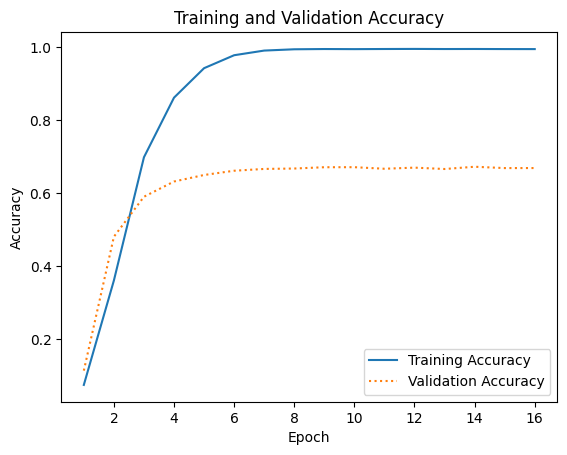

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

# Preprocess labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(tr_lb)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tr_img, train_labels_encoded, test_size=0.2, random_state=42)

# Print shapes for verification
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

# Define and compile the model
model = Sequential([
    Resizing(224, 224),
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=512, epochs=16)

# Plot training history
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# Test

## Load test data

In [30]:
test_dir = 'test'
dir = os.listdir(test_dir)
test_img = np.zeros((len(dir), 100, 100, 3))
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print(test_img.shape)
for filename in dir:
    id = int(filename[:-4])
    image_path = os.path.join(test_dir, filename)
    image = cv2.imread(image_path)
    if image is None:
      print("Error: Unable to read image at path:", image_path)
      continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    face = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(80, 80))
    if len(face) > 0:
        (x, y, w, h) = face[0]
        face_image = image[y:y+h, x:x+w]
        face_image = cv2.resize(face_image, (100, 100))
        test_img[id] = face_image

(4977, 100, 100, 3)


libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/4029.jpg
Error: Unable to read image at path: test/4175.jpg
Error: Unable to read image at path: test/1743.jpg
Error: Unable to read image at path: test/4405.jpg
Error: Unable to read image at path: test/4411.jpg
Error: Unable to read image at path: test/943.jpg


libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/361.jpg
Error: Unable to read image at path: test/4969.jpg


libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/3802.jpg
Error: Unable to read image at path: test/4374.jpg
Error: Unable to read image at path: test/2936.jpg
Error: Unable to read image at path: test/1231.jpg
Error: Unable to read image at path: test/3368.jpg
Error: Unable to read image at path: test/2499.jpg
Error: Unable to read image at path: test/1355.jpg
Error: Unable to read image at path: test/4826.jpg
Error: Unable to read image at path: test/1590.jpg
Error: Unable to read image at path: test/1208.jpg
Error: Unable to read image at path: test/2517.jpg


libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/165.jpg
Error: Unable to read image at path: test/4204.jpg
Error: Unable to read image at path: test/1140.jpg
Error: Unable to read image at path: test/1544.jpg
Error: Unable to read image at path: test/1550.jpg
Error: Unable to read image at path: test/991.jpg
Error: Unable to read image at path: test/238.jpg
Error: Unable to read image at path: test/1948.jpg
Error: Unable to read image at path: test/1784.jpg
Error: Unable to read image at path: test/101.jpg


libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/3137.jpg
Error: Unable to read image at path: test/1735.jpg
Error: Unable to read image at path: test/29.jpg
Error: Unable to read image at path: test/923.jpg
Error: Unable to read image at path: test/4855.jpg
Error: Unable to read image at path: test/1722.jpg
Error: Unable to read image at path: test/301.jpg
Error: Unable to read image at path: test/107.jpg
Error: Unable to read image at path: test/891.jpg
Error: Unable to read image at path: test/1054.jpg


libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/1280.jpg
Error: Unable to read image at path: test/3118.jpg
Error: Unable to read image at path: test/2819.jpg
Error: Unable to read image at path: test/2166.jpg
Error: Unable to read image at path: test/4847.jpg
Error: Unable to read image at path: test/4648.jpg
Error: Unable to read image at path: test/4890.jpg


libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/493.jpg
Error: Unable to read image at path: test/2220.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: gamma value does not match sRGB


Error: Unable to read image at path: test/2591.jpg
Error: Unable to read image at path: test/4692.jpg
Error: Unable to read image at path: test/4862.jpg
Error: Unable to read image at path: test/1259.jpg
Error: Unable to read image at path: test/4484.jpg
Error: Unable to read image at path: test/2037.jpg
Error: Unable to read image at path: test/1700.jpg


libpng warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/255.jpg
Error: Unable to read image at path: test/4684.jpg
Error: Unable to read image at path: test/452.jpg
Error: Unable to read image at path: test/1850.jpg
Error: Unable to read image at path: test/4041.jpg
Error: Unable to read image at path: test/867.jpg
Error: Unable to read image at path: test/132.jpg
Error: Unable to read image at path: test/668.jpg
Error: Unable to read image at path: test/2970.jpg
Error: Unable to read image at path: test/3663.jpg
Error: Unable to read image at path: test/866.jpg
Error: Unable to read image at path: test/2151.jpg
Error: Unable to read image at path: test/694.jpg
Error: Unable to read image at path: test/737.jpg
Error: Unable to read image at path: test/4481.jpg
Error: Unable to read image at path: test/736.jpg
Error: Unable to read image at path: test/246.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Error: Unable to read image at path: test/2337.jpg
Error: Unable to read image at path: test/4342.jpg
Error: Unable to read image at path: test/3404.jpg
Error: Unable to read image at path: test/3410.jpg
Error: Unable to read image at path: test/4155.jpg
Error: Unable to read image at path: test/4141.jpg
Error: Unable to read image at path: test/3799.jpg
Error: Unable to read image at path: test/2478.jpg
Error: Unable to read image at path: test/2685.jpg
Error: Unable to read image at path: test/3570.jpg
Error: Unable to read image at path: test/418.jpg


libpng warning: cHRM: invalid chromaticities


Error: Unable to read image at path: test/975.jpg
Error: Unable to read image at path: test/790.jpg
Error: Unable to read image at path: test/1947.jpg
Error: Unable to read image at path: test/3177.jpg
Error: Unable to read image at path: test/2651.jpg
Error: Unable to read image at path: test/3952.jpg
Error: Unable to read image at path: test/4620.jpg
Error: Unable to read image at path: test/1201.jpg
Error: Unable to read image at path: test/2324.jpg
Error: Unable to read image at path: test/1639.jpg
Error: Unable to read image at path: test/1407.jpg
Error: Unable to read image at path: test/1571.jpg


## Make prediction and Create csv file

In [31]:
print(test_img.shape)
pred = model.predict(test_img)
pred_lb = label_encoder.inverse_transform(np.argmax(pred, axis=1))

(4977, 100, 100, 3)
156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 522ms/step


In [32]:
submission_df = pd.DataFrame({'Id': range(len(pred_lb)), 'Category': pred_lb})
submission_df.to_csv('9352_min100.csv', index=False)
print(submission_df.shape)

(4977, 2)


Anna Kendrick


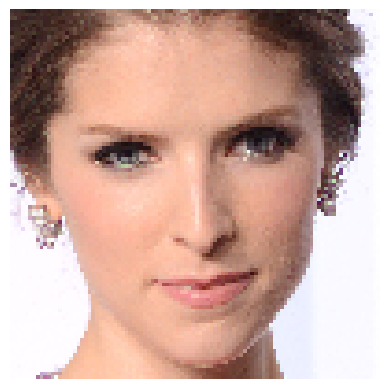

In [38]:
id_check = 226 # Bette Midler
# 22 # Benedict
# 92 # Amanda Seyfried
# 140 # Adele
# 177 # Amanda Seyfried
# 226 # Anna Kendrick
# 400 # Anthony Mackie
# 459 # Adrien Brody
# 2222 # Bette Midler
print(pred_lb[id_check])
plt.imshow((test_img[id_check]).astype(np.uint8))
plt.axis('off')
plt.show()